# ADM - HW04 
### Group_27 : Iason Tsardanidis, Marco Minici, Pol Ribó León

The purpose of this project is a first contact with the ideas of data scraping, clustering and hashing.




Importing the necessary libraries and external files

In [ ]:
from webscraper import WebScraper
from htmlprocessor import HtmlProcessor
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from random import randint
from stop_words import get_stop_words
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from wordcloud import WordCloud
import csv 
import nltk
import string
import re

In [ ]:
#initialize the object that will retrieve all the ads
webscraper = WebScraper("https://www.immobiliare.it")
#set the ratelimiter to avoid the IP to be banned while downloading the html files
#one hit can be done each 3 seconds.
webscraper.setRateLimiter(max_calls = 1, period = 3)

The assignment requires to download, at least, **10k** announcements from the *immobiliare.it* website.

Each page at *"https://www.immobiliare.it/vendita-case/roma/?criterio=rilevanza&pag=xxx"* contains **25** ads.

In order to download 10k announcements, it is needed to download *10k/25 = 400* of those webpages, but since not all ads contain the info that are needed, around **1000** webpages/**15000** house ads will be downloaded to be reasonably sure that the *"good"* ads are enough to reach the 10k data threshold.

In [ ]:
#Total number of webpages containing the house ads to download
NUMBER_OF_WEBPAGES = 1500
#Number of house ads to download
NUMBER_OF_ADS = 15000
#starting webpage at which the house ads list can be downloaded
startingwebpage = 495 
#variable used to index the html stored on the filesystem
#this variable need to be set, because other ads were previously downloaded
#so to not overwrite them, the index starts from @ad_index value
ad_index = 4599
#the base URL where all the house ads collection is contained
baseURL = "https://www.immobiliare.it/vendita-case/roma/?criterio=rilevanza&pag="
#the function which downloads all the html files is invoked
webscraper.downloadAllAds(ad_index = ad_index,NUMBER_OF_WEBPAGES = NUMBER_OF_WEBPAGES, NUMBER_OF_ADS = NUMBER_OF_ADS,startingwebpage = startingwebpage,baseURL = baseURL)

Once all the html files are downloaded, it is needed to build the two datasets required.

The first matrix will have this format: $m_{ij} = value$ where $i \in \{announcement_1, ..., announcement_n\}$ and $j \in \{price, locali, superficie, bagni, piano \}$. 

The second matrix will have this format: $m_{ij} = tfIdf_{ij}$ where $i \in \{announcement_1, ..., announcement_n\}$ and $j \in \{word_1, ...,word_m\}$. n is the number of the announcements and m is the cardinality of the vocabulary.

In [ ]:
#initialize the object that process the html files to build the two datasets
htmlProc = HtmlProcessor()

Create the first dataset.

In [ ]:
htmlProc.createFirstDataset()

Create the second dataset.

In [ ]:
htmlProc.createSecondDataset()

# CLUSTERING PART

**1st Matrix**

In [2]:
df = pd.read_csv('dataframe1.tsv',sep='\t',index_col=0)
data_1 = df.values
df.head()

,price,locali,superficie,bagni,piano
https://www.immobiliare.it/69855328-Vendita-Quadrilocale-viale-Londra-Roma.html,415000,4,130,2,3
https://www.immobiliare.it/70343506-Vendita-Bilocale-viale-Palmiro-Togliatti-Roma.html,128000,2,55,1,1
https://www.immobiliare.it/64286518-Vendita-Trilocale-via-Raimondo-Montecuccoli-14-Roma.html,215000,3,90,1,2
https://www.immobiliare.it/68397045-Vendita-Bilocale-via-Cardinale-Garampi-Roma.html,169000,2,64,1,1
https://www.immobiliare.it/62926454-Vendita-Attico-Mansarda-via-dell-Edera-50-Roma.html,215000,3,70,2,1


**2nd Matrix**

In [3]:
df = pd.read_csv('df2.tsv',sep='\t',index_col=0)
docs = list(df.index.values) #indices of each row advertisment
df.head()

,1,2,3,4,5,6,7,8,9,10,...,17658,17659,17660,17661,17662,17663,17664,17665,17666,17667
0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.050481,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.044684,0.0,0.0,0.0,0.061940,0.0,0.029046,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1002,0.046941,0.0,0.0,0.0,0.043379,0.0,0.030513,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1004,0.000000,0.0,0.0,0.0,0.023456,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


* here in matters of memory saving we convert the advertisments URLs in digits code. Nevertheless, the both matrices have the same elements in each row, more specificaly the advertisment of the 1st row of the 1st matrix is the same with the respective advertisment of the 1st line in the 2nd Matrix.

In [4]:
data_2 = df.values
del df


#pick a random sample in order to fit the classes
sample = data_2[[randint(0,len(data_2)-1) for p in range(1000)],:]  #pick a random sample in order to fit the classes

***Principal Component Analysis***

Since the second matrix has an extreme large number of features we decided to use principal component analysis in order to reduce the dimension of the matrix but at the same time keep as much information we can. [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) is a a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables (entities each of which takes on various numerical values) into a set of values of linearly uncorrelated variables called *principal components*. This transformation is defined in such a way that the first principal component has the largest possible variance (that is, accounts for as much of the variability in the data as possible), and each succeeding component in turn has the highest variance possible under the constraint that it is orthogonal to the preceding components. Choosing the variance at level 0.9 we keep all the n first elements of the produces matrix with variance over that threshold.

The results are promising since the dimension of the features reduced significant around 95%. That was expected since in order to construct the second matrix we use the sparse matrix, thing that imply that a lot of memory consumed in zeros and empty cells.

***MinMaxScaler transformation***

Moreover in order to have normalized parameters we used the [MinMaxScaler transformation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) in order to construct a normalized second matrix between zero and one devided the difference of each element from the total minimum with the maximum length, using the mathematical formula below:

\begin{align}
X_{norm} = \frac{X - X_{min}}{X_{max} - X_{min}}\\
\end{align}

In [6]:
pca = PCA(0.9)  #Principal Component Analysis in order to reduce data_2 matrix dimensions
principalComponents = pca.fit(sample)
sample = principalComponents.transform(sample)
scaler = MinMaxScaler().fit(sample) #MinMaxScaler regularization in order to normalize the prices of second Matrix

In [7]:
data_2 = principalComponents.transform(data_2)
data_2 = scaler.transform(data_2)

**elbow_method**

In this step in order to find the best number of cluster in order to feat the KMeans algorithm as best as we can we apply the [elbow criterion](https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set) showing the point before the _inertia_ of clustering starting to reach a stable point. 

In [8]:
seed = 1234 #set_random_seed
error = []
K = range(1,25)
for i in range(1,3):
    ds = eval('data_'+str(i))
    KM = [KMeans(n_clusters=k,init='k-means++',random_state=seed).fit(ds) for k in K]
    centroids = [k.cluster_centers_ for k in KM]
    #computing distance of each element from all the centroids
    D_k = [cdist(ds, cent, 'euclidean') for cent in centroids]  
    #and finding the closest from them
    dist = [np.min(D,axis=1) for D in D_k]
    error.append([sum(d**2) for d in dist])    

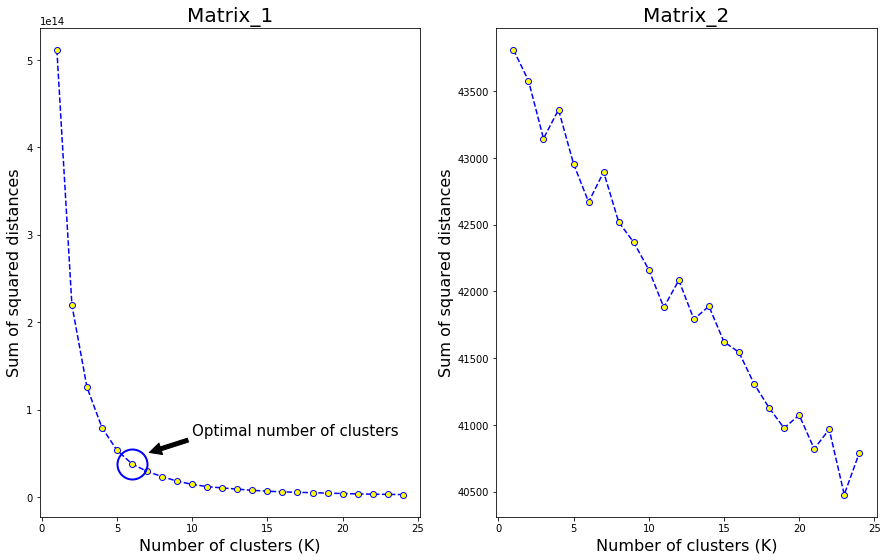

In [9]:
fig, ax = plt.subplots(1,2,figsize=[15,9])
titles = ['Matrix_1','Matrix_2']
for i in range(2):
    ax[i].plot(K, error[i], 'bx-',marker = '.',linestyle='--',markerfacecolor='yellow',markersize=12)
    ax[i].set_xlabel('Number of clusters (K)',fontsize=16)
    ax[i].set_ylabel('Sum of squared distances',fontsize=16)
    ax[i].set_title(titles[i],fontsize=20)
    if i == 0:
        ax[i].plot(K[5],error[i][5],'o',ms=30,mec='b',mfc='none',mew=2)
        ax[i].annotate('Optimal number of clusters',xy=(7,5e13),xytext=(10,7e13),arrowprops=dict(facecolor='black',shrink=0.05),fontsize=15)

* *For the second matrix the elbow rule cannot be applied, since the error tend to reducing continiously. So we choose the best number of clusters taking into account only the first matrix*

**Fitting Data**

Taking **K = 6** as optimal number of clusters we fit the 2 kMeans models.

In [10]:
K = 6
kmeans_1 = KMeans(n_clusters=K,init='k-means++',random_state=seed).fit(data_1)
kmeans_2 = KMeans(n_clusters=K,init='k-means++',random_state=seed).fit(data_2)


#assign each advertisment to the clusters that belongs to.
#Create 2 dictionaries with advertisments allocated to the clusters they belong to.

k_1 = kmeans_1.labels_
clus_1 = {i:[] for i in range(K)}
for i in range(len(k_1)):
    clus_1[k_1[i]].append(i)
    
k_2 = kmeans_2.labels_
clus_2 = {i:[] for i in range(K)}
for i in range(len(k_2)):
    clus_2[k_2[i]].append(i)    

**Jaccard Similarity and 3 most similar clusters**

Using [Jaccard Index](https://en.wikipedia.org/wiki/Jaccard_index) we create a matrix showing the clusters from each model and which of them are more similar. Jaccard index take values between (0,1). As a result the closed to one is one cell, the more similar these clusters are!

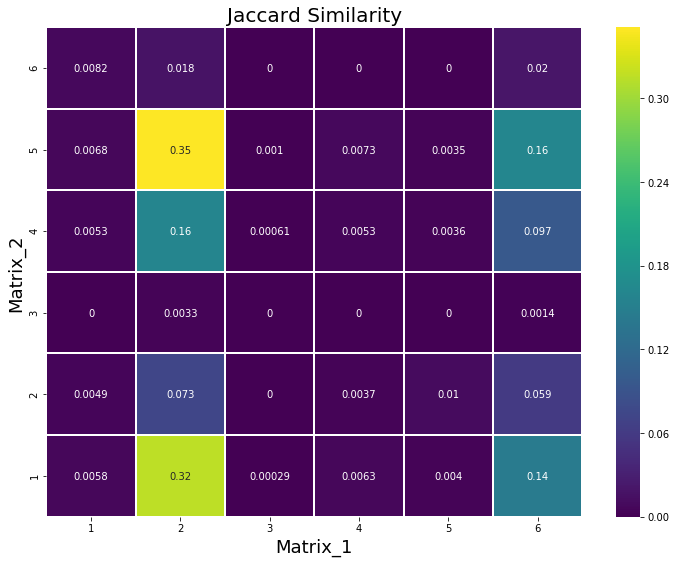

In [11]:
M = np.zeros([K,K])
for i in range(K):
    for j in range(K):
        M[i,j] = len(set(clus_1[i]).intersection(set(clus_2[j])))/len(set(clus_1[i]).union(set(clus_2[j])))
m1,m2 = M.flatten().argsort()[::-1][0:3]//K,M.flatten().argsort()[::-1][0:3]%K
m = list(zip(m1,m2))

M = pd.DataFrame(M)

plt.figure(figsize=(12,9))
ax = sns.heatmap(M,xticklabels=M.columns+1,yticklabels=M.columns+1,annot=True,cmap='viridis',linewidths=1)
ax.invert_yaxis()
plt.xlabel('Matrix_1',fontsize=18)
plt.ylabel('Matrix_2',fontsize=18)
plt.title('Jaccard Similarity',fontsize=20)
plt.show()

* Above we can see a heetmap show clearly the most similar pairs of clusters between the 2 models

**WORDCLOUD**

[WordCloud](https://www.datacamp.com/community/tutorials/wordcloud-python) is a novelty visual representation of text data. Inmost usual type, size represents the number of times that tag has been applied to a single item.

In [13]:
#fuction for string cleaning from unwanted punctuation symbols and spaces.
def string_cleaning(string_raw):

    m = string_raw.replace('\\r', ' ').replace('\\n', ' ')
    m = re.sub('[%s]' % re.escape(string.punctuation), ' ', m)
    m = re.sub(r'(?<=[\d+])(?=[a-zA-Z_])', r' ', m)
    string_new = ''
    for word in m:
        string_new +=  word
    
    return string_new

In [14]:
stop_words = list(get_stop_words('italian'))

stopwords = list(['rif','fu', 'stiate', 'ad', 'stemmo', 'quello', 'dei', 'miei', 'ho', 'siete', 'sue', 'dov', 'siano', 'avevamo', 'saremo', 'sto', 'uno', 'vostri', 'quelli', 'quanto', 'staranno', 'sarai', 'di', 'avuti', 'pi\xf9', 'star\xf2', 'dal', 'tra', 'degl', 'facevate', 'stareste', 'stai', 'abbiate', 'del', 'eravamo', 'avrei', 'li', 'mio', 'quanta', 'ebbe', 'avemmo', 'mie', 'sulla', 'fecero', 'io', 'ha', 'allo', 'avesti', 'tuoi', 'farai', 'con', 'cui', 'facevo', 'lui', 'mia', 'facciamo', 'sull', 'sua', 'ed', 'staremmo', 'stetti', 'facciano', 'sugl', 'sulle', 'stando', 'nostra', 'non', 'siamo', 'stia', 'ci', 'fossero', 'avevano', 'contro', 'vostra', 'avr\xe0', 'starete', 'dalle', 'quante', 'ebbi', 'sarete', 'stavamo', 'faceva', 'starebbe', 'tuo', 'su', 'stesse', 'lo', 'aveste', 'fossimo', 'avreste', 'ne', 'furono', 'vostre', 'l', 'e', 'hanno', 'quanti', 'suoi', '\xe8', 'far\xe0', 'dagli', 'i', 'staremo', 'dallo', 'tutto', 'chi', 'perch\xe9', 'si', 'faremo', 'staresti', 'ai', 'al', 'era', 'dall', 'lei', 'nello', 'loro', 'avremmo', 'questo', 'avessimo', 'sta', 'stavate', 'sarebbero', 'facendo', 'avendo', 'stiamo', 'il', 'nelle', 'quale', 'hai', 'fossi', 'avesse', 'all', 'che', 'fosti', 'feci', 'starei', 'faceste', 'queste', 'col', 'sei', 'starai', 'faccia', 'faranno', 'facesti', 'la', 'facevano', 'starebbero', 'quella', 'avresti', 'dove', 'se', 'avranno', 'avrebbero', 'far\xf2', 'coi', 'dell', 'sareste', 'stessero', 'alla', 'saranno', 'fosse', 'anche', 'facevamo', 'c', 'negli', 'fece', 'stiano', 'avuto', 'avremo', 'eri', 'nostri', 'sar\xf2', 'fanno', 'stavano', 'alle', 'nostro', 'stava', 'abbiamo', 'fummo', 'tue', 'per', 'sia', 'facemmo', 'sul', 'agli', 'tutti', 'stesti', 'sar\xe0', 'fui', 'facessi', 'nella', 'negl', 'stavo', 'da', 'o', 'voi', 'suo', 'come', 'sarei', 'dagl', 'nell', 'ebbero', 'della', 'sullo', 'le', 'avuta', 'ero', 'a', 'sarebbe', 'fareste', 'tu', 'aveva', 'saresti', 'stettero', 'abbiano', 'vostro', 'quelle', 'faccio', 'sui', 'eravate', 'mi', 'avete', 'farete', 'nei', 'sono', 'gli', 'degli', 'avessi', 'agl', 'facevi', 'avr\xf2', 'stette', 'stanno', 'questi', 'avevo', 'farebbe', 'avrebbe', 'stessi', 'delle', 'tua', 'una', 'saremmo', 'sugli', 'ma', 'stessimo', 'avessero', 'siate', 'facesse', 'stavi', 'nostre', 'erano', 'avute', 'faresti', 'faremmo', 'star\xe0', 'avrai', 'avrete', 'dello', 'in', 'steste', 'ti', 'avevate', 'questa', 'farebbero', 'foste', 'nel', 'facessimo', 'dai', 'abbia', 'farei', 'un', 'noi', 'essendo', 'dalla', 'vi', 'avevi', 'facessero', 'facciate', 'fai'])

#final stopwords list
for word in stop_words:
     stopwords.append(word)

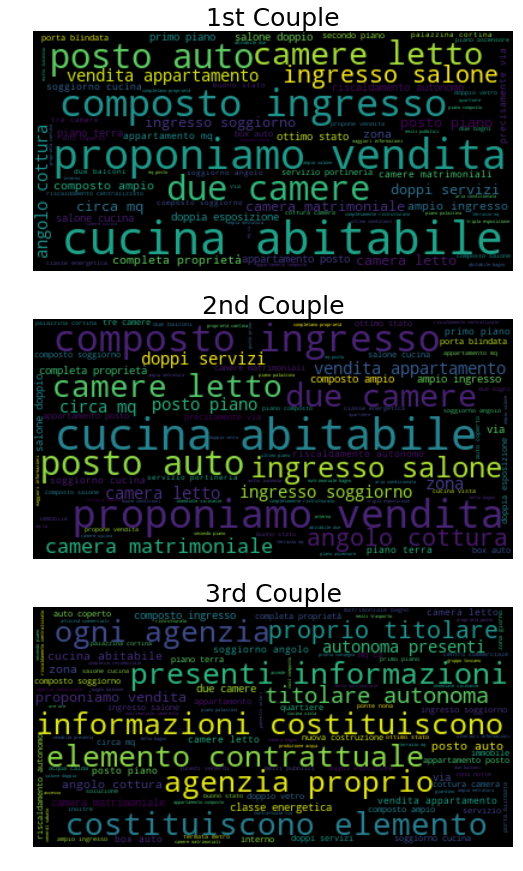

In [15]:
fig, ax = plt.subplots(3,1,figsize=(15,15))
titles = ['1st Couple','2nd Couple','3rd Couple']
stopwords = set(stopwords)
for t in range(3):
    c = set(clus_1[m[t][0]]).intersection(set(clus_2[m[t][1]]))
    bag_of_words = []
    for x in c:
        filename = 'descriptions/descriptionAD#{}.txt'.format(int(docs[x]))
        with open(filename,encoding='utf8') as tsvfile:
            reader = csv.reader(tsvfile, delimiter='\t')
            document = []
            for row in reader:
                if len(row) > 0:
                    document.append(string_cleaning(row[0]))
            bag_of_words.append(document)

    text = ""
    for i in bag_of_words:
        text += str(i) + "-"
    wordcloud = WordCloud(stopwords=stopwords,max_words=1000).generate(text.lower())
    ax[t].imshow(wordcloud, interpolation='bilinear')
    ax[t].set_title(titles[t],fontsize=25)
    ax[t].axis('off')
plt.show()

* Above we can see that inside the 3 wordclouds, terms relative to house renting are dominating. In the 3 cases these terms are similar, showing the most common words appeared in the advertisments of our dataset.

# BONUS

In [16]:
data = data_1
K = 6

At these point we will construct a default clustering algorithm with random initialization (**NOT ++**) that we will apply it in the first matrix since it is the most handable. In first case we created a K_Means function in common python enviromens and in the second case we tried to generalize the function in [MapReduce](https://en.wikipedia.org/wiki/MapReduce) environment using *PySpark*.

## K-means algorithm

In [18]:
def KMeans(X,k,max_iter = 200):
    m = X.shape[0]
    centroids = X[np.random.choice(m,k,replace=False,)]
    itr = 0
    clus = {i:[] for i in range(k)}
    while True:
        #assign each point to the closest cluster
        for i in range(m):
            d = np.sum((X[i] - centroids)**2,axis = 1)
            clus[np.argmin(d)] += [i]
        #define old centroids
        oldCentroids = centroids.copy()
        #recalculate new centroids
        for i in range(k):
            centroids[i] = np.mean(X[clus[i]],axis=0)
        itr += 1
        #if centroids remain the same, algorithm stops!!!
        if (centroids == oldCentroids).all() or itr >= max_iter:
            return clus,centroids

In [19]:
clusters,centroids = KMeans(data,K)

# MapReduce

In [20]:
def closestPoint(x, centers):
    bestIndex = 0
    closest = float("+inf")
    for i in range(len(centers)):
        tempDist = np.sum((x - centers[i]) ** 2)
        if tempDist < closest:
            closest = tempDist
            bestIndex = i
    return bestIndex

In [22]:
d = sc.parallelize(data)

kCentroids = d.takeSample(False, K, 1)
oldPoints = sc.parallelize(np.zeros([K,len(data[0])]))
while oldPoints != kCentroids:
    #assign each point to the closest centroid
    closest = d.map(lambda x: (closestPoint(x, kCentroids), (x, 1)))
    #reducing by key and add all same centroids points
    pointStats = closest.reduceByKey(lambda x1_c1, x2_c2: (x1_c1[0] + x2_c2[0], x1_c1[1] + x2_c2[1]))
    #find the new centroid mean
    newPoints = pointStats.map(lambda st: (st[0], st[1][0] / st[1][1])).collect()

    #ending condition when new and old centroids remain the same
    oldPoints = kCentroids
    for (iK, p) in newPoints:
        kCentroids[iK] = p

In [23]:
clust = sc.parallelize([(x[1][0],x[0]) for x in enumerate(closest.collect())])
finalresult = clust.groupByKey().map(lambda x : (x[0], list(x[1]))).sortByKey(True).collect()

### Matrix 1 centroids illustration with 3 methods

In last step we will try to show how similar are the results produced from the 3 Methods:

* SkLearn (K-Means ++)
* Default Funtion (random initialization - NOT ++)
* MapReduce

We will illustrate via scatter_plot how far the centroids calculated from these methods are to each other, and how similar the methods are.

Moreover in order to depict the results in two diminsion we will implement principal component analysis in order to reduce the dimensions of the centroids from 5 to 2, and have a better intuition of the result

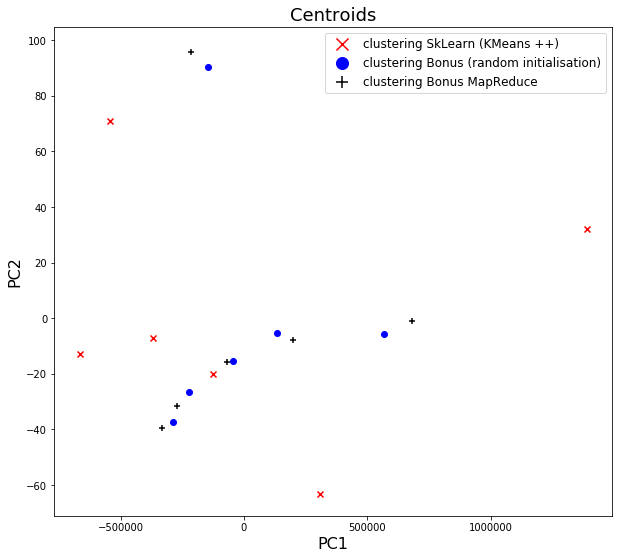

In [24]:
pca = PCA(2)
cl_1 = pca.fit_transform(kmeans_1.cluster_centers_)
cl_2 = pca.fit_transform(centroids)
cl_3 = pca.fit_transform(kCentroids)

fig = plt.figure(figsize=(10,9))
plt.scatter(cl_1[:,0],cl_1[:,1],marker='x',c='red',label='clustering SkLearn (KMeans ++)',)
plt.scatter(cl_2[:,0],cl_2[:,1],marker='o',c='blue',label='clustering Bonus (random initialisation)')
plt.scatter(cl_3[:,0],cl_3[:,1],marker='+',c='black',label='clustering Bonus MapReduce')
plt.legend(loc="upper right", markerscale=2., scatterpoints=1, fontsize=12)
plt.title('Centroids',fontsize=18)
plt.xlabel('PC1',fontsize=16)
plt.ylabel('PC2',fontsize=16)
plt.show()

* As we can see from the graph above the centroids from the 3 last methods are very close to each other, so the results are similar, something that we expected since the method is the same but applied in different environment. The method of SkLearn produced a bit different results, but we don't worry for the reason that the centroids in this case calculated with the ++ optimized algorithm.

# HASHING PART

Importing all the necessary libraries

In [2]:
import os
from tqdm import tqdm
from os import listdir
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib as plt
import numpy as np
import matplotlib.pylab as plt
from os.path import isfile


The assignment requires to design two hashing functions for a collection of passwords in order to detect the number of duplicates.

The hashing function is a mathematical function which takes as input a general object and outputs an integer.

The goal of designing an hashing function is to create a mathematical function which satisfy the injective property, simply put, mapping distinct elements of its domain to the distinct element of its codomain.

We know that each passwords has a length of 20 characters, if we suppose that each character is encoded in ASCII, in order to create a 'perfect'([*injective*](https://en.wikipedia.org/wiki/Injective_function))hashing functions the codomain would satisfy the condition of mapping 128^20 = 1,3938*10^42 all possible values.

It is known that there are 110M passwords in the passwords2.txt file given as the dataset of the assignment(this info has been retrieved using the BASH command line function wc -l passwords2.txt).

It is also known that there are 10M duplicates if the character order into the strings isn't considered. This means that, in this particular case, the designed hash function, to be perfect, requires as a **necessary condition** that the cardinality of its image must be at least 100M*(TOTAL_NUMBER_OF_PASSWORDS-#OFDUPLICATES=#OFDISTINCT_ELEMENTS).*

It is not possible to design a perfect function using as codomain cardinality the lower bound of 100M, in fact this would require to realize a function that maps 'perfectly' all of the passwords in our domain which it is almost impossible to do.

Since we are not very good mathematicians(even data scientists as well, perhaps) we need to push at the maximum the computation capabilities of our machine, especially in terms of RAM total space.

Since one of the sentences in the assignment asks to check the strings that create false positives, the first idea was to build a dictionary which had as keys the hashing values and as values the list of the passwords(the row index integer to spare memory space), also known as bucket, which gives that specific hash value. This would allow us, once this dictionary is built, to visit each entry with a bucket length > 1(where collisions happened) and to check the false positives comparing the string representation of the passwords in the same bucket. The realization of such a dictionary on our "low-constraints" computing machines(4GB) was **totally unfeasible.**

This brought us to think of a possible smarter solution which could spare space in memory. We decided to use the bit-array data structure, which is a simple array where each element is a bit. Its usage in our problem was crucial because it allowed us to ramatically increase the codomain cardinality of the hash function, the consequence was the detection of more duplicates and therefore the decrease of the false positives. The bit-array has a length equal to the codomain cardinality of the hash function and, each time an hashing value HASH is computed, the HASH-th element of the bit-array is flipped to 1.(the array is initialized will all 0s)

What is the methodology to compute the # of duplicates and the # of false positives? The number of distinct passwords is given by the number of 1s in the bit-array, therefore the number of duplicates is given by the formula *TOTAL_NUMBER_OF_PASSWORDS - {# of 1s in the bit-array}*, once the # of duplicates is retrieved it is possible to compute the number of false positives, thanks to the previous domain knowledge, the # of duplicates from the **real** number of duplicates given in the assignment(this is possible only when we consider the passwords not considering the characters order)

After trying some hashing function, the choice has gone on the [djb2](http://www.cse.yorku.ca/~oz/hash.html) algorithm which is very powerful for string hashing at the current state of the art.

The "size" parameter choice decision was lead by trying to select the highest possible number, in order to increase the maximum codomain cardinality, but following the constraint of having a prime number. This is due to the fact that a prime number minimizes the number of multiples which could lead the modulo operation to output zero creating many unwanted collisions.

Many parameters were tried and it follows the plot showing the hashing function performances.

In [3]:
#total number of passwords in the passwords2.txt
TOTAL_NUMBER_OF_PASSWORDS = 110000000

### HASHING FUNCTIONS

In [5]:
# Hash function to hash a string for a given table size. Based on Dan Bernstein's djb2
def quickhash(mystr, size):
    h = 3313  # arbitrary large prime number to initialize

    for char in mystr:
        # hash(i) = hash(i-1) * 33 + str[i]
        h = ((h << 5) + h) + ord(char)

    #return int(long(h)%long(size))  # python 2.7 needs some overflow magic
    return h%size

In [6]:
def quickhash_no_Order(mystr, size):
    h = 3313  # arbitrary large prime number to initialize
    
    for char in ''.join(sorted(mystr)):#sort characters so that order doesn't matter
          h = ((h << 5) + h) + ord(char)    

    return h%size

### EXAMPLE QUICKHASH (ORDER MATTERS)

In [18]:
PRIME_NUMBER = 110000017

In [19]:
bitArray=[False]*PRIME_NUMBER 

In [20]:
#folder into which all files(splitted before) cotaining the passwords are contained
directory = "./passwords/"
#this dictionary will contain as key the output coming from the hashing functions and
#as value the list of the row_index(passwords) that produce that specific hash value
#hashings = {}


#for each file
for filePath in tqdm(listdir(directory)):
    #open the file in read-only
    with open(directory+filePath, 'r') as file:
        #read the first line
        line = file.readline()
        #while the line isn't the EOF
        while(line):
            #compute the hashing for that password
            hashing = quickhash(line,size=PRIME_NUMBER)
            #free the memory
            del line
            #updating the bitarray value
            bitArray[hashing] = True
            #a new line is read to navigate through the file
            line = file.readline()

100%|████████████████████████████████████████████| 8/8 [12:04<00:00, 86.86s/it]


In [21]:
number_of_distinct = sum(bitArray)

In [22]:
number_of_distinct

67656131

In [23]:
TOTAL_NUMBER_OF_PASSWORDS - number_of_distinct

42343869

### PERFORMANCE QUICKHASH( ORDER MATTERS)

------**bitArray of size 110000017**

Number_of_distinct = 67656131  
Number_of_duplicates = TOTAL_NUMBER_OF_PASSWORDS - number_of_distinct = **42343869 duplicates**

------**bitArray of size 198491317**

Number_of_distinct = 81540272  
Number_of_duplicates = TOTAL_NUMBER_OF_PASSWORDS - number_of_distinct = **28459728 duplicates**

*Comment: There is a strong decrease in the duplicates, good.*

------**bitArray of size 295075147**

Number_of_distinct = 88342827  
Number_of_duplicates = TOTAL_NUMBER_OF_PASSWORDS - number_of_distinct = **21657173 duplicates**

*Comment: There is a decrease in the duplicates.*

------**bitArray of size 393342739**

Number_of_distinct = 92157914  
Number_of_duplicates = TOTAL_NUMBER_OF_PASSWORDS - number_of_distinct = **17842086 duplicates**

*Comment: There is another decrease, but it's possible to observe a sublinear trend, infact in the decreasing.
This means that increasing the cardinality of the codomain of the hashfunction of 100 doesn't correspond
to a decrease of the duplicates of 100, but something less.*

------**bitArray of size 512927357** 

Number_of_distinct = 94944819  
Number_of_duplicates = TOTAL_NUMBER_OF_PASSWORDS - number_of_distinct = **15055181 duplicates**

*Comment: This increase in the size of the bit array lead to an improve of the hashing function performance
but it's definitely observable how the increase rate starts to flattening.*

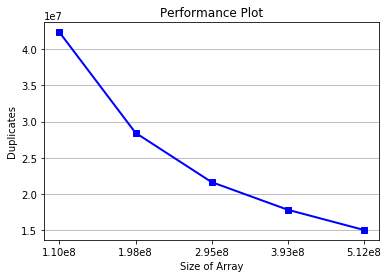

In [35]:
y=[42343869,28459728,21657173,17842086,15055181]
x=range(len(y))

plt.xticks([r for r in range(len(y))], ['1.10e8','1.98e8','2.95e8','3.93e8','5.12e8'])
plt.title('Performance Plot')
plt.xlabel('Size of Array')
plt.ylabel('Duplicates')
plt.grid(axis='y', linestyle='-')
plt.plot(y, color='blue', linewidth='2')
plt.plot(y, 'bs')
plt.show()

### EXAMPLE QUICKHASH_NO_ORDER (ORDER DOESN'T MATTERS)

In [24]:
PRIME_NUMBER = 110000017

In [25]:
bitArray=[False]*PRIME_NUMBER 

In [26]:
#folder into which all files(splitted before) cotaining the passwords are contained
directory = "./passwords/"
#this dictionary will contain as key the output coming from the hashing functions and
#as value the list of the row_index(passwords) that produce that specific hash value
#hashings = {}


#for each file
for filePath in tqdm(listdir(directory)):
    #open the file in read-only
    with open(directory+filePath, 'r') as file:
        #read the first line
        line = file.readline()
        #while the line isn't the EOF
        while(line):
            #compute the hashing for that password
            hashing = quickhash_no_Order(line,size=PRIME_NUMBER)
            #free the memory
            del line
            #updating the bitarray value
            bitArray[hashing] = True
            #a new line is read to navigate through the file
            line = file.readline()

100%|███████████████████████████████████████████| 8/8 [16:25<00:00, 122.68s/it]


In [28]:
number_of_distinct = sum(bitArray)

In [29]:
number_of_distinct

65680588

In [30]:
TOTAL_NUMBER_OF_PASSWORDS - number_of_distinct

44319412

### PERFORMANCE QUICKHASH_NO_ORDER( ORDER DOESN'T MATTER)

------**bitArray of size 110000017**


Number_of_duplicates = TOTAL_NUMBER_OF_PASSWORDS - number_of_distinct = **44319412 duplicates**




------**bitArray of size 160481183**

Number_of_duplicates = TOTAL_NUMBER_OF_PASSWORDS - number_of_distinct = **38275934 duplicates**



------**bitArray of size 198491317**

Number_of_duplicates = TOTAL_NUMBER_OF_PASSWORDS - number_of_distinct = **31672153 duplicates**



------**bitArray of size 217645177**

Number_of_duplicates = TOTAL_NUMBER_OF_PASSWORDS - number_of_distinct = **26703949 duplicates**


------**bitArray of size 275604541**

Number_of_duplicates = TOTAL_NUMBER_OF_PASSWORDS - number_of_distinct = **24106741 duplicates**



------**bitArray of size 295075147**

Number_of_duplicates = TOTAL_NUMBER_OF_PASSWORDS - number_of_distinct = **23404983 duplicates**



------**bitArray of size 314606869**

Number_of_duplicates = TOTAL_NUMBER_OF_PASSWORDS - number_of_distinct = **22619231 duplicates**



------**bitArray of size 334214459**

Number_of_duplicates = TOTAL_NUMBER_OF_PASSWORDS - number_of_distinct = **22073921 duplicates**



------**bitArray of size 353868013**

Number_of_duplicates = TOTAL_NUMBER_OF_PASSWORDS - number_of_distinct = **21821028 duplicates**



*Comment: We noticed that when order doesn't matter there are more duplicates if array size are equaL.*




**FYI: Arrays of more size couldn't have been run due to lack of computational power**

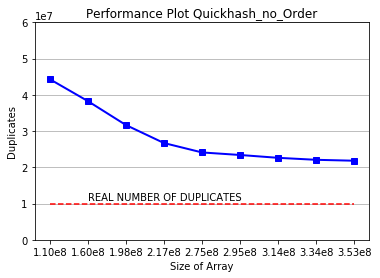

In [33]:
y=[44319412,38275934,31672153,26703949,24106741,23404983,22619231,22073921,21821028]
x=range(len(y))
t=[10000000,10000000,10000000,10000000,10000000,10000000,10000000,10000000,10000000]
plt.xticks([r for r in range(len(y))],['1.10e8','1.60e8','1.98e8','2.17e8','2.75e8','2.95e8','3.14e8','3.34e8','3.53e8'])
#plt.yticks([r for r in range(len(y))], )
plt.title('Performance Plot Quickhash_no_Order')
plt.xlabel('Size of Array')
plt.ylabel('Duplicates')
plt.plot(y, 'bs')
#plt.hlines(t, 'r--',label='REAL NUMBER OF DUPLICATES')
plt.plot(t,'r--',label='REAL NUMBER OF DUPLICATES')
plt.grid(axis='y', linestyle='-')
plt.plot(y, color='blue', linewidth='2')
plt.ylim([0,60000000])

plt.text(1.,11000000,'REAL NUMBER OF DUPLICATES')
plt.show()

*We can see that as a bigger array is used, the number of duplicates tends to reach 10M which is the actual number of duplicates stated in the statement.*